## * Imports & Config

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, InceptionV3, Xception
from tensorflow.keras.callbacks import EarlyStopping


## Configuration

In [4]:
DATA_DIR = "/kaggle/input/fake-news-detection-bilingual-multimodel-fusion/news_dataset/for_image"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20


## Load Dataset

In [6]:
dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 9936 files belonging to 2 classes.
Classes: ['fake', 'real']


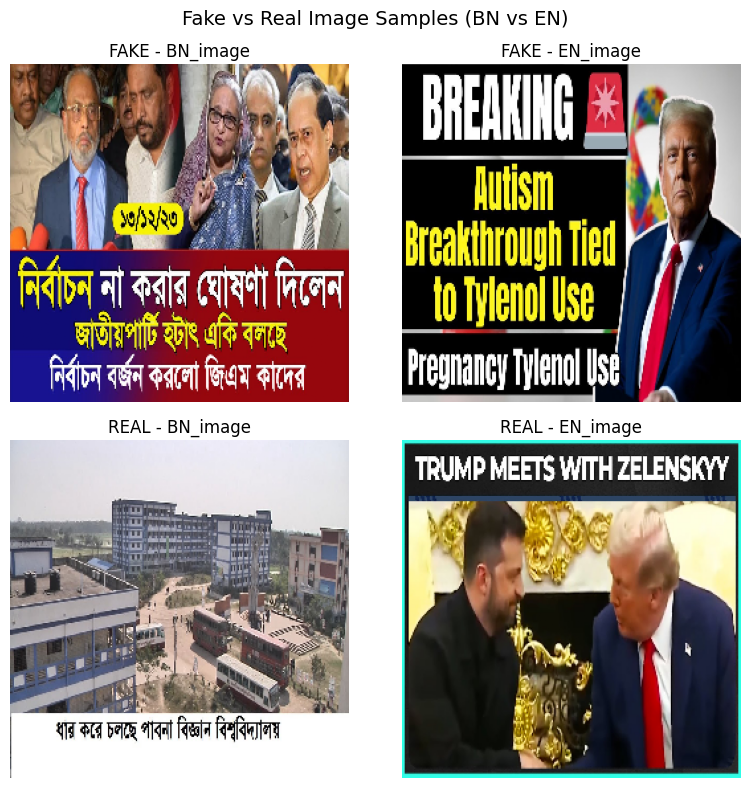

In [7]:
def load_random_image(folder, img_size=(256, 256)):
    img_name = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_name)
    img = tf.keras.utils.load_img(img_path, target_size=img_size)
    img = tf.keras.utils.img_to_array(img) / 255.0
    return img


categories = [
    ("fake", "BN_image"),
    ("fake", "EN_image"),
    ("real", "BN_image"),
    ("real", "EN_image")
]

plt.figure(figsize=(8, 8))

for i, (label, lang) in enumerate(categories):
    folder_path = os.path.join(DATA_DIR, label, lang)
    img = load_random_image(folder_path, IMG_SIZE)

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(f"{label.upper()} - {lang}")
    plt.axis("off")

plt.suptitle("Fake vs Real Image Samples (BN vs EN)", fontsize=14)
plt.tight_layout()
plt.show()


{'fake': {'BN': 2941, 'EN': 2502}, 'real': {'BN': 2478, 'EN': 2015}}


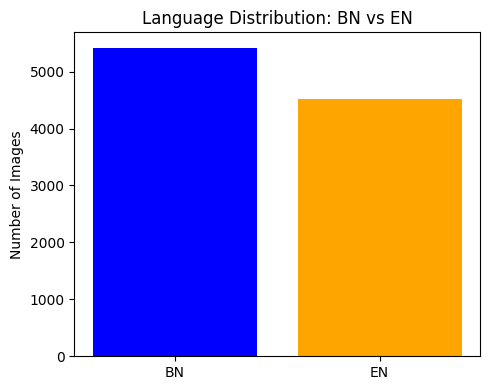

In [8]:
def count_images(data_dir):
    counts = {
        "fake": {"BN": 0, "EN": 0},
        "real": {"BN": 0, "EN": 0}
    }

    for label in ["fake", "real"]:
        for lang, folder_name in [("BN", "BN_image"), ("EN", "EN_image")]:
            folder = os.path.join(data_dir, label, folder_name)
            if os.path.exists(folder):
                counts[label][lang] = len(os.listdir(folder))

    return counts

counts = count_images(DATA_DIR)
print(counts)


languages = ["BN", "EN"]
language_counts = [
    counts["fake"]["BN"] + counts["real"]["BN"],
    counts["fake"]["EN"] + counts["real"]["EN"]
]

plt.figure(figsize=(5, 4))
plt.bar(languages, language_counts, color=["blue", "orange"])
plt.ylabel("Number of Images")
plt.title("Language Distribution: BN vs EN")
plt.tight_layout()
plt.show()


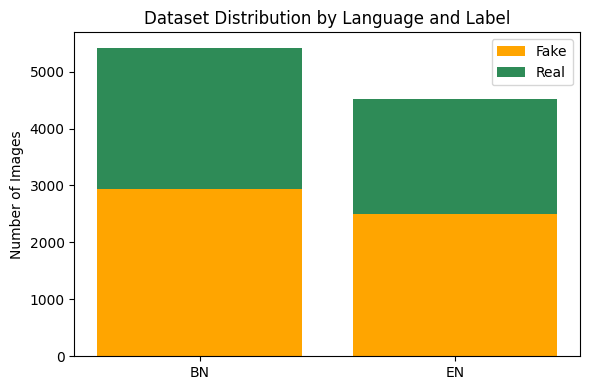

In [9]:
fake_counts = [counts["fake"]["BN"], counts["fake"]["EN"]]
real_counts = [counts["real"]["BN"], counts["real"]["EN"]]

x = range(len(languages))

plt.figure(figsize=(6, 4))
plt.bar(x, fake_counts, label="Fake", color="orange")
plt.bar(x, real_counts, bottom=fake_counts, label="Real", color="seagreen")

plt.xticks(x, languages)
plt.ylabel("Number of Images")
plt.title("Dataset Distribution by Language and Label")
plt.legend()
plt.tight_layout()
plt.show()


## Preprocessing

In [10]:
def normalize_data(data):
    return data.map(lambda x, y: (x / 255.0, y))

def split_data(data, train_ratio=0.7, val_ratio=0.15):
    total = len(data)

    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size)

    return train, val, test

def optimize_pipeline(ds):
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Apply preprocessing
dataset = normalize_data(dataset)
train, val, test = split_data(dataset)

train = optimize_pipeline(train)
val = optimize_pipeline(val)
test = optimize_pipeline(test)


In [11]:
print("Total batches:", len(dataset))
print("Train batches:", len(train))
print("Validation batches:", len(val))
print("Test batches:", len(test))

Total batches: 311
Train batches: 217
Validation batches: 46
Test batches: 48


## All CNN based Models

In [12]:


def get_model(model_name, input_shape=(256, 256, 3)):

    # -------------------------
    # Base CNN (32-64-128, MaxPool, Flatten)
    # -------------------------
    if model_name == "base_cnn":
        model = Sequential([
            Conv2D(32, 3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(64, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(128, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    # -------------------------
    # AvgPool CNN (Pooling ablation)
    # -------------------------
    elif model_name == "avgpool_cnn":
        model = Sequential([
            Conv2D(32, 3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            AveragePooling2D(pool_size=(2, 2)),

            Conv2D(64, 3, activation='relu'),
            BatchNormalization(),
            AveragePooling2D(pool_size=(2, 2)),

            Conv2D(128, 3, activation='relu'),
            BatchNormalization(),
            AveragePooling2D(pool_size=(2, 2)),

            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    # -------------------------
    # GAP CNN (Flatten vs GAP)
    # -------------------------
    elif model_name == "gap_cnn":
        model = Sequential([
            Conv2D(32, 3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(64, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(128, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            GlobalAveragePooling2D(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    # -------------------------
    # Constant Filters CNN (32-32-32)
    # -------------------------
    elif model_name == "constant_filters_cnn":
        model = Sequential([
            Conv2D(32, 3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(32, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(32, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    # -------------------------
    # Shallow CNN (only two conv blocks)
    # -------------------------
    elif model_name == "shallow_cnn":
        model = Sequential([
            Conv2D(32, 3, activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(64, 3, activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    else:
        raise ValueError("Unknown model name")

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


## Evaluation Function

In [13]:
def evaluate_model(model, test, model_name, plot_cm=True):
    y_true, y_pred = [], []

    for x, y in test:
        preds = model.predict(x, verbose=0)
        preds = (preds > 0.5).astype(int)

        y_true.extend(y.numpy())
        y_pred.extend(preds.flatten())

    # Metrics
    acc = accuracy_score(y_true, y_pred)

    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )
    p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro"
    )
    p_weighted, r_weighted, f_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )

    # Print results
    print(f"\n===== Evaluation Results: {model_name} =====")
    print(f"Accuracy            : {acc:.4f}")
    print("\nMacro Average")
    print(f"  Precision         : {p_macro:.4f}")
    print(f"  Recall            : {r_macro:.4f}")
    print(f"  F1-score          : {f_macro:.4f}")

    print("\nMicro Average")
    print(f"  Precision         : {p_micro:.4f}")
    print(f"  Recall            : {r_micro:.4f}")
    print(f"  F1-score          : {f_micro:.4f}")

    print("\nWeighted Average")
    print(f"  Precision         : {p_weighted:.4f}")
    print(f"  Recall            : {r_weighted:.4f}")
    print(f"  F1-score          : {f_weighted:.4f}")
    print("=" * 40)

    # Confusion Matrix
    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(model_name)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision (Macro)": p_macro,
        "Recall (Macro)": r_macro,
        "F1 (Macro)": f_macro,
        "Precision (Micro)": p_micro,
        "Recall (Micro)": r_micro,
        "F1 (Micro)": f_micro,
        "Precision (Weighted)": p_weighted,
        "Recall (Weighted)": r_weighted,
        "F1 (Weighted)": f_weighted
    }

## Offline Tracking

In [14]:
import os
import json
from tensorflow.keras.models import save_model

LOG_DIR = "/kaggle/working/mlruns"  # offline "mlflow" directory
os.makedirs(LOG_DIR, exist_ok=True)

def log_offline(
    model,
    model_name,
    metrics,
    history,
    epochs,
    batch_size,
    img_size,
    model_path
):
    """
    Logs model, parameters, metrics, and training history offline.
    """
    run_dir = os.path.join(LOG_DIR, model_name)
    os.makedirs(run_dir, exist_ok=True)

    # Save parameters
    params = {
        "model": model_name,
        "epochs": epochs,
        "batch_size": batch_size,
        "image_size": img_size,
        "saved_model_path": model_path
    }
    with open(os.path.join(run_dir, "params.json"), "w") as f:
        json.dump(params, f, indent=4)

    # Save metrics
    metrics_to_save = {
        "test_accuracy": metrics["Accuracy"],
        "test_f1_micro": metrics["F1 (Micro)"],
        "test_f1_macro": metrics["F1 (Macro)"],
        "test_f1_weighted": metrics["F1 (Weighted)"],
        "best_val_accuracy": max(history.history["val_accuracy"])
    }
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics_to_save, f, indent=4)

    # Save training history
    with open(os.path.join(run_dir, "history.json"), "w") as f:
        json.dump(history.history, f, indent=4)

    # Save model
    save_model(model, model_path)
    print(f"Run logged offline at {run_dir}")


In [15]:
def save_trained_model(model, model_name):
    save_dir = "/kaggle/working/saved_models"
    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, f"{model_name}.keras")
    model.save(model_path)

    print(f"**Model saved to: {model_path}")
    return model_path

## Comparison Table

In [16]:
def update_comparison_table(metrics, model_name):
    row = {
        "Model": model_name,
        "Accuracy": metrics["Accuracy"],
        "F1 Micro": metrics["F1 (Micro)"],
        "F1 Macro": metrics["F1 (Macro)"],
        "F1 Weighted": metrics["F1 (Weighted)"],
    }

    path = "/kaggle/working/model_comparison.csv"

    if os.path.exists(path):
        df = pd.read_csv(path)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(path, index=False)
    return df

## Tranining(Base CNN)  

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 233ms/step - accuracy: 0.7238 - loss: 2.6036 - val_accuracy: 0.5231 - val_loss: 0.6496
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.7951 - loss: 0.4317 - val_accuracy: 0.8560 - val_loss: 0.3466
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8362 - loss: 0.3214 - val_accuracy: 0.9001 - val_loss: 0.2287
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.8526 - loss: 0.2964 - val_accuracy: 0.9300 - val_loss: 0.1840
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.8747 - loss: 0.2300 - val_accuracy: 0.9450 - val_loss: 0.1111
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.8898 - loss: 0.1865 - val_accuracy: 0.9586 - val_loss: 0.1023
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.9341 - loss: 0.1504 - val_accuracy: 0.9470 - val_loss: 0.1174
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.9312 - loss: 0.1420 -

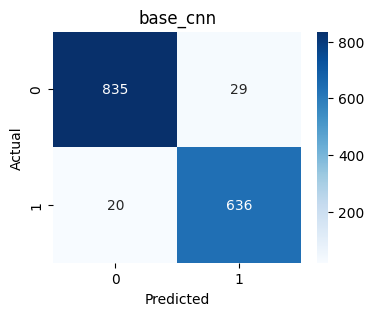

**Model saved to: /kaggle/working/saved_models/base_cnn.keras
Run logged offline at /kaggle/working/mlruns/base_cnn


In [18]:
MODEL_NAME = "base_cnn"

early_stop = EarlyStopping(
    monitor="val_loss",        # or "val_accuracy"
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop], 
    verbose=1
)

# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)

df = update_comparison_table(metrics, MODEL_NAME)

## Training AvgPool CNN (Pooling ablation)

Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.7361 - loss: 3.2945 - val_accuracy: 0.4457 - val_loss: 0.7536
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.8764 - loss: 0.3309 - val_accuracy: 0.4457 - val_loss: 0.7622
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9284 - loss: 0.1864 - val_accuracy: 0.5550 - val_loss: 1.9963
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9470 - loss: 0.1349 - val_accuracy: 0.9321 - val_loss: 0.1621
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9690 - loss: 0.0905 - val_accuracy: 0.9497 - val_loss: 0.2046
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9673 - loss: 0.0835 - val_accuracy: 0.8118 - val_loss: 0.9350
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9673 - loss: 0.0873 - val_accuracy: 0.9518 - val_loss: 0.1910
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.9752 - loss: 0.0652 - 

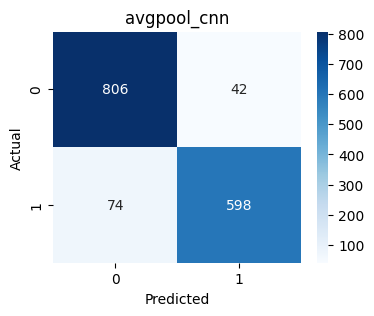

**Model saved to: /kaggle/working/saved_models/avgpool_cnn.keras
Run logged offline at /kaggle/working/mlruns/avgpool_cnn


In [35]:
MODEL_NAME = "avgpool_cnn"


early_stop = EarlyStopping(
    monitor="val_loss",        # or "val_accuracy"
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop], 
    verbose=1
)


# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)

df = update_comparison_table(metrics, MODEL_NAME)

## Training GAP CNN (Flatten vs GAP)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 19s 65ms/step - accuracy: 0.7322 - loss: 0.5334 - val_accuracy: 0.4457 - val_loss: 1.0448
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.8302 - loss: 0.3860 - val_accuracy: 0.4457 - val_loss: 1.1394
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8664 - loss: 0.3028 - val_accuracy: 0.4654 - val_loss: 1.0053
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8914 - loss: 0.2643 - val_accuracy: 0.8825 - val_loss: 0.2717
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9063 - loss: 0.2310 - val_accuracy: 0.8784 - val_loss: 0.2865
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9176 - loss: 0.1974 - val_accuracy: 0.9307 - val_loss: 0.1931
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.9237 - loss: 0.1867 - val_accuracy: 0.9124 - val_loss: 0.2389
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.9409 - loss: 0.1520 - val_accurac

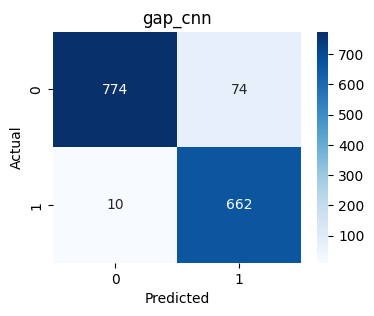

**Model saved to: /kaggle/working/saved_models/gap_cnn.keras
Run logged offline at /kaggle/working/mlruns/gap_cnn


In [36]:
MODEL_NAME = "gap_cnn"

early_stop = EarlyStopping(
    monitor="val_loss",        # or "val_accuracy"
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop], 
    verbose=1
)

# 🔹 Evaluate (now evaluates BEST model)
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save BEST model
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)

df = update_comparison_table(metrics, MODEL_NAME)

## Training Constant Filters CNN (32-32-32)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.7397 - loss: 0.9405 - val_accuracy: 0.4457 - val_loss: 35.8283
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.8667 - loss: 0.3930 - val_accuracy: 0.4457 - val_loss: 37.4799
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8737 - loss: 0.3323 - val_accuracy: 0.5068 - val_loss: 3.5688
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9155 - loss: 0.1991 - val_accuracy: 0.9375 - val_loss: 0.1535
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9332 - loss: 0.1323 - val_accuracy: 0.9586 - val_loss: 0.1115
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9466 - loss: 0.1110 - val_accuracy: 0.9524 - val_loss: 0.1266
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9493 - loss: 0.1338 - val_accuracy: 0.9654 - val_loss: 0.1249
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9661 - loss: 0.0864 - val_accur

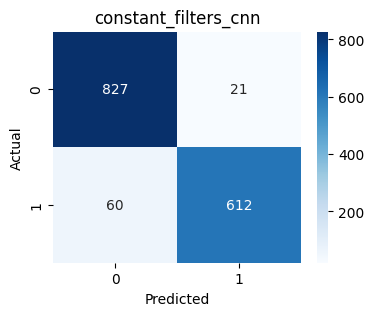

**Model saved to: /kaggle/working/saved_models/constant_filters_cnn.keras
Run logged offline at /kaggle/working/mlruns/constant_filters_cnn


In [37]:
MODEL_NAME = "constant_filters_cnn"

early_stop = EarlyStopping(
    monitor="val_loss",        # or "val_accuracy"
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop], 
    verbose=1
)

# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)

df = update_comparison_table(metrics, MODEL_NAME)

## Training Shallow CNN (only two conv blocks)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.8115 - loss: 0.6469 - val_accuracy: 0.4457 - val_loss: 0.8387
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9372 - loss: 0.1561 - val_accuracy: 0.4457 - val_loss: 0.8780
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9529 - loss: 0.1198 - val_accuracy: 0.8587 - val_loss: 0.3280
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9755 - loss: 0.0703 - val_accuracy: 0.9721 - val_loss: 0.0859
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9768 - loss: 0.0762 - val_accuracy: 0.9463 - val_loss: 0.2437
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.9726 - loss: 0.0690 - val_accuracy: 0.9606 - val_loss: 0.0972
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9798 - loss: 0.0498 - val_accuracy: 0.9647 - val_loss: 0.1643
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.9878 - loss: 0.0327 - val_accurac

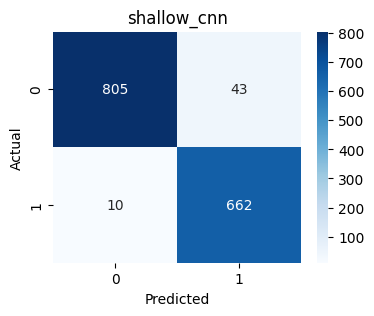

**Model saved to: /kaggle/working/saved_models/shallow_cnn.keras
Run logged offline at /kaggle/working/mlruns/shallow_cnn


In [38]:
MODEL_NAME = "shallow_cnn"

early_stop = EarlyStopping(
    monitor="val_loss",        # or "val_accuracy"
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop], 
    verbose=1
)

# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)

df = update_comparison_table(metrics, MODEL_NAME)

In [27]:
path = "/kaggle/working/model_comparison.csv"
# 🔹 Update comparison table (optional)

df.to_csv(path, index=False)

In [28]:
df

,Model,Accuracy,F1 Micro,F1 Macro,F1 Weighted
0,base_cnn,0.967800,0.967800,0.967200,0.967800
1,avgpool_cnn,0.923684,0.923684,0.922228,0.923460
2,gap_cnn,0.944737,0.944737,0.944435,0.944909
3,constant_filters_cnn,0.946711,0.946711,0.945623,0.946513
4,shallow_cnn,0.965132,0.965132,0.964820,0.965203


In [24]:
df = pd.DataFrame({'Model': ['base_cnn', 'avgpool_cnn', 'gap_cnn', 'constant_filters_cnn', 'shallow_cnn'], 'Accuracy': [0.9678, 0.923684, 0.944737, 0.946711, 0.965132], 'F1 Micro': [0.9678, 0.923684, 0.944737, 0.946711, 0.965132], 'F1 Macro': [0.9672, 0.922228, 0.944435, 0.945623, 0.964820], 'F1 Weighted': [0.9678, 0.923460, 0.944909, 0.946513, 0.965203]})

In [ ]:
import shutil

shutil.make_archive('/kaggle/working/mlruns', 'zip', '/kaggle/working/mlruns')


In [ ]:
from IPython.display import FileLink

# Make sure path matches exactly
zip_path = "/kaggle/working/mlruns.zip"

# Display clickable download link
display(FileLink(zip_path))


In [ ]:
import os

print("Exists:", os.path.exists(zip_path))
print("Size (MB):", os.path.getsize(zip_path) / (1024 * 1024))


In [ ]:
import os

# List files in /kaggle/working/
print(os.listdir('/kaggle/working/'))
